In [21]:
from scipy.io import loadmat
from pathlib import Path
import numpy as np
from suite2p.registration.register import compute_filters_and_norm, compute_shifts
from suite2p.io import BinaryFile
from suite2p.logger import TqdmToLogger
from tqdm import trange

import torch
device = torch.device('cuda')

In [53]:
root = Path('M:/VG14/2024_11_23/3')
data = loadmat(root / 'zstack.mat')
Zstack = data['Z'].squeeze()
print(Zstack.shape)

settings = np.load('D:/PROC_test/VG14/2024_11_23/3/suite2p/plane8/settings.npy', allow_pickle=True).item()
db = np.load('D:/PROC_test/VG14/2024_11_23/3/suite2p/plane8/db.npy', allow_pickle=True).item()
Ly, Lx = db['Ly'], db['Lx']
reg_settings = settings['registration']
for k in reg_settings.keys():
    print(k, reg_settings[k])
    vars()[k] = reg_settings[k]
nonrigid = False

(10,)
align_by_chan2 False
nimg_init 400
maxregshift 0.1
do_bidiphase False
bidiphase 0.0
batch_size 100
nonrigid True
maxregshiftNR 5
block_size [128.0, 128.0]
smooth_sigma_time 0.0
smooth_sigma 1.15
spatial_taper 3.45
th_badframes 1.0
norm_frames True
snr_thresh 1.2
subpixel 10
two_step_registration False
reg_tif False
reg_tif_chan2 False


In [54]:
with BinaryFile(filename='D:/PROC_test/VG14/2024_11_23/3/suite2p/plane8/data.bin', 
                Ly=Ly, Lx=Lx) as f_align_in:
    refImg = list(Zstack[8].transpose(2, 1, 0))

    n_frames, Ly, Lx = f_align_in.shape
    print(f"Data shape: {f_align_in.shape}")

    if isinstance(refImg, list):
        nZ = len(refImg)
        print(f"List of reference frames len = {nZ}")
    else:
        nZ = 1

    refAndMasks = compute_filters_and_norm(refImg, norm_frames=norm_frames, 
                                            spatial_smooth=smooth_sigma,
                                            spatial_taper=spatial_taper, 
                                            block_size=block_size if nonrigid else None, 
                                            device=device)
    blocks = refAndMasks[-3] if nZ==1 else refAndMasks[0][-3]
    rmin = refAndMasks[-2] if nZ==1 else [refAndMasks[z][-2] for z in range(nZ)]
    rmax = refAndMasks[-1] if nZ==1 else [refAndMasks[z][-1] for z in range(nZ)]
    ### ------------- register frames to reference image ------------ ###

    mean_img = np.zeros((Ly, Lx), "float32")

    n_batches = int(np.ceil(n_frames / batch_size))
    #logger.info(f"Registering {n_frames} frames in {n_batches} batches")
    for n in trange(n_batches, mininterval=10):
        tstart, tend = n * batch_size, min((n+1) * batch_size, n_frames)
        frames = f_align_in[tstart : tend]
        if device.type == "cuda":
            fr_torch = torch.from_numpy(frames).pin_memory().to(device)
        else:
            fr_torch = torch.from_numpy(frames).to(device)
        if bidiphase != 0:
            fr_torch = bidi.shift(fr_torch, bidiphase)

        fr_reg = fr_torch.clone()
        offsets = compute_shifts(refAndMasks, fr_reg, maxregshift=maxregshift, 
                                    smooth_sigma_time=smooth_sigma_time, 
                                    snr_thresh=snr_thresh, maxregshiftNR=maxregshiftNR, 
                                    nZ=nZ)
        ymax, xmax, cmax, ymax1, xmax1, cmax1, zest, cmax_all = offsets
        
        # convert to numpy and concatenate offsets
        ymax, xmax, cmax = ymax.cpu().numpy(), xmax.cpu().numpy(), cmax.cpu().numpy()
        if ymax1 is not None:
            ymax1, xmax1 = ymax1.cpu().numpy(), xmax1.cpu().numpy()
            cmax1 = cmax1.cpu().numpy()
        offsets = [ymax, xmax, cmax, ymax1, xmax1, cmax1, zest, cmax_all]
        offsets_all = ([np.concatenate((offset_all, offset), axis=0) 
                        if offset is not None else None
                        for offset_all, offset in zip(offsets_all, offsets)] 
                        if n > 0 else offsets)

Data shape: (13009, 860, 462)
List of reference frames len = 13


100%|██████████| 131/131 [01:46<00:00,  1.24it/s]


In [55]:
cmax_all = offsets_all[-1]

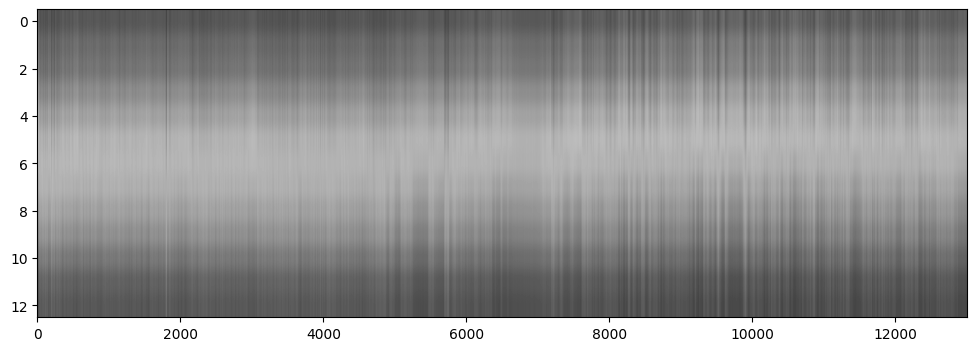

In [56]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.imshow(offsets_all[-1].T, cmap='gray', vmin=0, vmax=0.05, aspect='auto')

Text(0.5, 1.0, 'best matching z-plane')

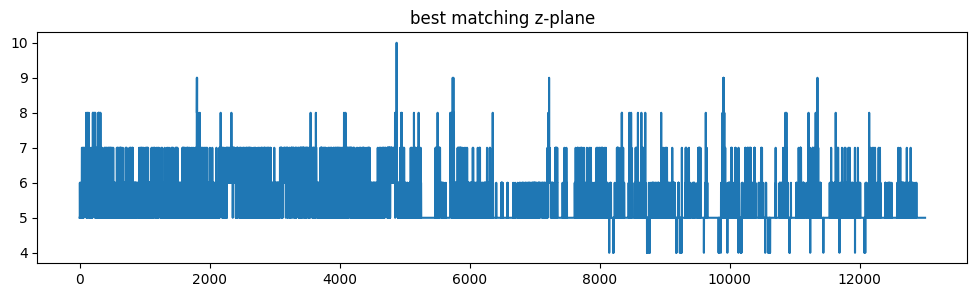

In [57]:
plt.figure(figsize=(12,3))
plt.plot(cmax_all.argmax(axis=1))
plt.title('best matching z-plane')

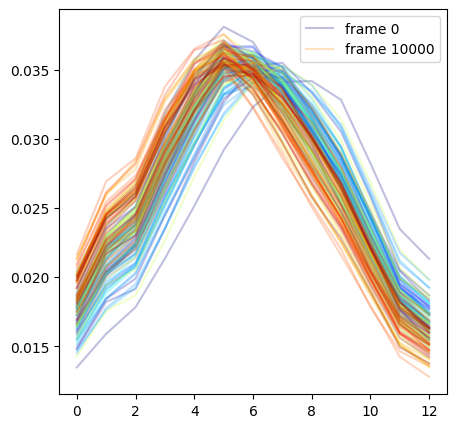

In [58]:
plt.figure(figsize=(5, 5))
cmap = plt.get_cmap('jet')(np.linspace(0, 1, len(cmax_all)//100 + 1))
lg = []
for i in np.arange(0, len(cmax_all), 100):
    l0, = plt.plot(cmax_all[i], color=cmap[i//100], alpha=0.25)
    lg.append(l0)
#plt.plot(cmax_all[::100].T);
plt.legend(lg[::100], [f'frame {i}' for i in range(0, len(cmax_all), 100*100)])